In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import scipy
from sklearn import linear_model
from sklearn import neighbors
from sklearn.cross_decomposition import PLSRegression

In [4]:
# Import data

dc = pd.read_csv('/Users/justinsmith/Documents/GitHub/DC_Properties.csv')

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Data to clean and model

dc_re = dc.dropna(subset=['PRICE'])

In [10]:
# Seperating residential and condominium  

dc_re_resid = dc_re[dc_re['SOURCE'] == 'Residential']
dc_re_condo = dc_re[dc_re['SOURCE'] != 'Residential']

In [11]:
# exploring data

dc_re_resid['diff_yr'] = abs(dc_re_resid['EYB']- dc_re_resid['YR_RMDL'])
dc_re_condo['diff_yr'] = abs(dc_re_condo['EYB']- dc_re_condo['YR_RMDL'])
dc_re_resid = dc_re_resid.drop(index=56600)

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/justinsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


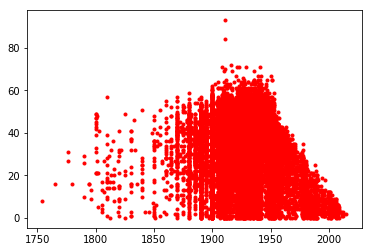

In [12]:
plt.plot(dc_re_resid['AYB'], dc_re_resid['diff_yr'], 'r.')

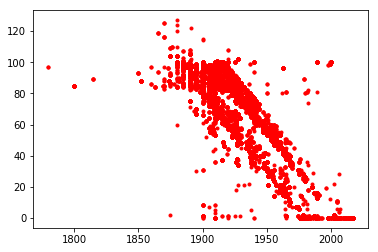

In [13]:
plt.plot(dc_re_condo['AYB'], dc_re_condo['diff_yr'], 'r.')

In [14]:
# Filling NA in year columns

dc_re_resid['AYB'] = dc_re_resid['AYB'].fillna(0)
dc_re_resid['YR_RMDL'] = dc_re_resid['YR_RMDL'].fillna(0)
dc_re_resid['EYB'] = dc_re_resid['EYB'].fillna(0)

In [15]:
# Cleaning actual year built, year remodel, and effective year built. 

for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,8] == 0:
        dc_re_resid.iloc[i,8] = dc_re_resid.iloc[i,10]

for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,9]  == 0:
        dc_re_resid.iloc[i,9] = dc_re_resid.iloc[i,10]\
        
for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,8] > dc_re_resid.iloc[i,10]:
        dc_re_resid.iloc[i,10] = dc_re_resid.iloc[i,8]
        
for i in range(len(dc_re_resid)):
    if dc_re_resid.iloc[i,10] > dc_re_resid.iloc[i,9]:
        dc_re_resid.iloc[i,9] = dc_re_resid.iloc[i,10]

In [17]:
# DEALING WITH NULLS AND COLUMNS

dc_re_resid.dropna(axis=1, how='all', inplace=True)
dc_re_resid.drop(columns=['Unnamed: 0','FULLADDRESS', 'CENSUS_BLOCK', 'diff_yr', 'NATIONALGRID',
                          'ASSESSMENT_SUBNBHD','X','Y','GIS_LAST_MOD_DTTM','SOURCE', 
                          'QUADRANT'], inplace=True)
dc_re_resid.dropna(inplace=True)

In [18]:
# Cleaning data types

dc_re_resid['SALEDATE']  = pd.to_datetime(dc_re_resid['SALEDATE']).dt.date
dc_re_resid['SALEDATE']= pd.to_datetime(dc_re_resid['SALEDATE'])

dc_re_resid['WARD'] = dc_re_resid['WARD'].str.extract('(\d+)', expand=False)
dc_re_resid['WARD'] = dc_re_resid['WARD'].astype('int')

dc_re_resid['SQUARE'].replace(to_replace='PAR ', value= 9999, inplace=True)
dc_re_resid['SQUARE'] = dc_re_resid['SQUARE'].astype('int')

dc_re_resid['USECODE'] = dc_re_resid['USECODE'].astype('int')

In [20]:
# Dealing with date of sale data

dc_re_resid[['year','month','day']] = dc_re_resid.SALEDATE.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
dc_re_resid.drop(columns=['day','SALEDATE'], inplace=True)

In [22]:
dc_re_resid_dummies = pd.get_dummies(dc_re_resid)

In [24]:
X = dc_re_resid_dummies.drop(columns='PRICE')
y = dc_re_resid_dummies['PRICE'].values.reshape(-1, 1)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=36)

In [32]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
print('\nCoefficients: \n', regr.coef_)


Coefficients: 
 [[ 3.93083018e+04  1.76011616e+04 -1.22019515e+05 -1.39170260e+03
  -5.25036516e+03 -1.75452760e+03 -1.04135408e+03  2.12061642e+03
   7.04348119e+02  3.51529696e+03  1.84282147e+02  1.32060304e+06
   4.12716346e+04  3.72783167e+04  7.07336893e+03  3.91539875e+01
   1.58258307e+03 -9.16612460e+05 -2.57882243e+06 -4.75936163e+00
  -2.12191610e+04 -1.35808861e+01 -5.88225698e+04  3.41479201e+04
   2.73585721e+04  9.45687481e+03 -2.87506050e+05  1.42454830e+04
   6.55099945e+04  1.75997713e+04  4.43344283e+04  1.82848151e+04
   2.99077626e+04  1.06988006e+04  4.33984419e+04  3.13857554e+04
  -1.18945484e+05  6.76165687e+04  5.13289152e+04  4.07871712e+04
  -4.07871712e+04  1.78499641e+04 -1.73297577e+04  4.04644429e+04
  -2.23535269e+04 -4.01953776e+04 -2.53761649e+04 -3.35551952e+04
  -5.24739635e+04  5.51147462e+05  1.40662445e+04 -1.37473300e+05
  -2.18686468e+05  2.24388893e+04 -1.57457906e+05  7.92342744e+04
  -2.02996171e+04  8.56525730e-08 -4.89259372e+05 -4.971046

In [34]:
print('\nIntercept: \n', regr.intercept_)


Intercept: 
 [-1.91719673e+08]


In [35]:
print('\nR-squared:')
print(regr.score(X_train, y_train))


R-squared:
0.7504144140248127


In [38]:
y_pred_regr = regr.predict(X_test)

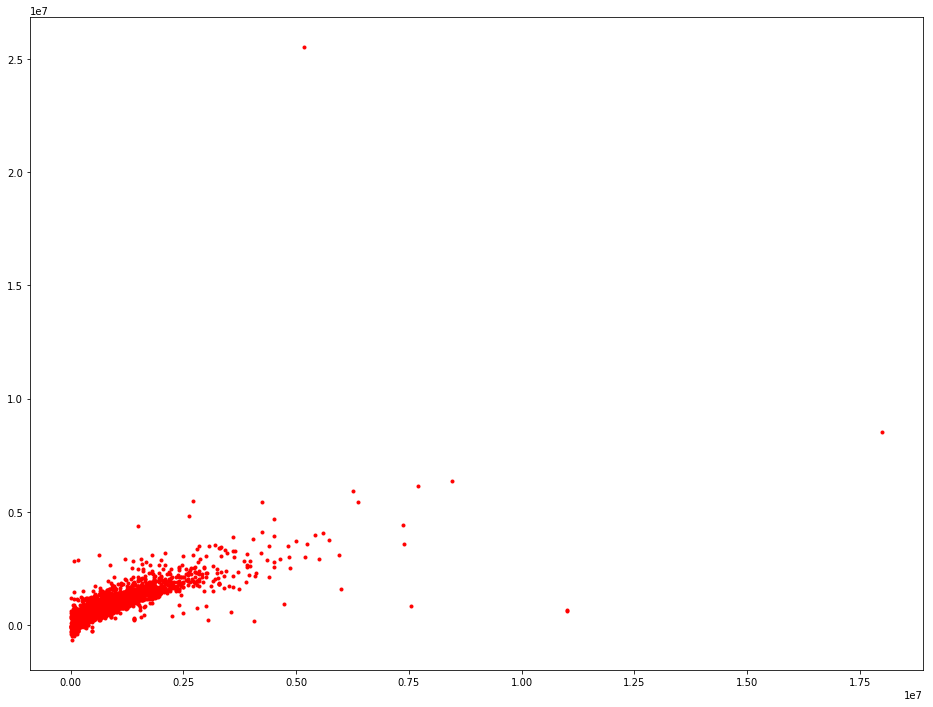

In [45]:
plt.figure(figsize=(16,12))
plt.plot(y_test, y_pred_regr,'r.')

In [52]:
pls1 = PLSRegression(n_components=25)

In [59]:
fit = pls1.fit(X_train, y_train)

In [76]:
pls1.fit(X_test, y_test)

PLSRegression(copy=True, max_iter=500, n_components=25, scale=True, tol=1e-06)

In [77]:
pls1.score(X_test,y_test)

0.7513591582752291

In [62]:
Y_PLS_pred = fit.predict(X_test)

In [67]:
print(Y_PLS_pred)

[[948089.17397437]
 [574834.78602701]
 [432248.79458223]
 ...
 [400587.27894688]
 [-75163.43838308]
 [619569.77876399]]


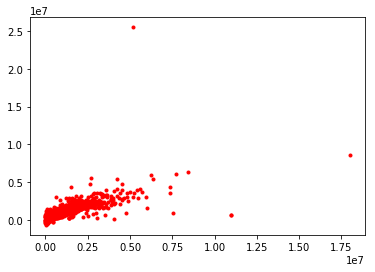

In [66]:
plt.plot(y_test,Y_PLS_pred, 'r.')

In [73]:
ridgeregr = linear_model.Ridge(alpha=5, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [74]:
ridgeregr.score(X_train,y_train)

0.7353882609150021

In [75]:
ridgeregr.score(X_test, y_test)

0.7101264855044662

In [78]:
lass = linear_model.Lasso(alpha=.5)

In [80]:
lass.fit(X_train, y_train)

/Users/justinsmith/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [81]:
lass.score(X_train, y_train)

0.7504136842376015

In [ ]:
lass.score()